# Retinal Disease Detection and Classification

## By: Jalen Wu, Yechan Na, Jonathan Zhang

__Project Description:__

The goal of this project is to develop a machine learning model capable of detecting retinal diseases by analyzing fundus images of the eye. Using computer vision and deep learning techniques, the model assists in early detection and diagnosis of retinal disease(s).

__Applications and Impact:__

This project could be used for clinical screening to help ophthalmologists identify diseases and improve efficiency on identifying these diseases. This automated detection system has the potential to make medical imaging diagnostics more accessible.

__What we hope to achieve:__

We hope to build a model that takes in images of the eye and accurately predicts whether an individual’s eyes are healthy or showing signs of disease. To quantify the effectiveness of our model, we will be measuring metrics such as F1 score, precision, recall, loss, and accuracy of our models and graphing them as a function of how many epochs we run on our training data (all of these scores should increase in subsequent epochs).

- __Dataset__: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/data
- __References__: 
    - https://www.mdpi.com/2306-5729/6/2/14
    - https://jamanetwork.com/journals/jama/fullarticle/2588763
    

In [1]:
# imports

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import os
from torch.utils.data import Dataset
import pandas as pd
from skimage import io, transform
from torch import tensor
from PIL import Image
from torch import flatten

In [2]:
# Import Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

c:\Users\Jalen\anaconda3\envs\cuda_environment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Jalen\.cache\kagglehub\datasets\andrewmvd\retinal-disease-classification\versions\1


In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# X = 1424 x 2144 x 3 : h x w x colors
# y = label
transform = transforms.Compose([
    transforms.Resize((int(1424 / 4), int(2144 / 4))), # Standardize image dimensions to 1424 x 2144
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

base_directory = path  
print(base_directory)

if os.path.exists(base_directory):
    print("Directory exists and its contents are:")
    print(os.listdir(base_directory))
else:
    print("Directory does not exist.")

C:\Users\Jalen\.cache\kagglehub\datasets\andrewmvd\retinal-disease-classification\versions\1
Directory exists and its contents are:
['Evaluation_Set', 'Test_Set', 'Training_Set']


In [17]:
# Constants (paths that will be accessed later in the project)
BASE_DIRECTORY = path
TRAINING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'Training')
TRAINING_LABELS = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'RFMiD_Training_Labels.csv')
TESTING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'Test')
TESTING_LABELS = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'RFMiD_Testing_Labels.csv')

In [18]:
class MultiClassDataset(Dataset):
    """
    Supports structure of given dataset (images in child folder and labels in csv format).
    """
    def __init__(self, label_csv_file, image_directory, transform=transform):
        """
        Args:
            label_csv_file (DataFrame): the Dataframe containing the labels for the image set.
            image_directory (str): Directory with eye images.
            transform (callable, optional): transform function to be applied to each image.
        """
        self.label_csv_file = label_csv_file
        self.image_directory = image_directory
        self.transform = transform
    
    def __len__(self):
        return len(self.label_csv_file)    

    def __getitem__(self, index):
        # Load image
        image_path = os.path.join(self.image_directory, str(index + 1) + '.png')
        current_image = io.imread(image_path)
        current_image = Image.fromarray(current_image)

        # Apply transforms to the image
        if self.transform:
            current_image = self.transform(current_image)

        # Load label and convert to a class index
        image_label = self.label_csv_file.iloc[index]
        image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer

        return {'image': current_image, 'label': image_label}

In [19]:
# Initializes dataframe before passing it into the Dataset and drops first two columns.
training_label_df = pd.read_csv(TRAINING_LABELS)
training_label_df = training_label_df.drop(columns=['ID', 'Disease_Risk'])

# Testing dataframe
testing_label_df = pd.read_csv(TESTING_LABELS)
testing_label_df = testing_label_df.drop(columns=['ID', 'Disease_Risk'])

# Initializing training dataset and loader.
train_dataset = MultiClassDataset(label_csv_file=training_label_df, image_directory=TRAINING_DIRECTORY, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64)

# Initializing testing dataset and loader.
test_dataset = MultiClassDataset(label_csv_file=testing_label_df, image_directory=TESTING_DIRECTORY, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)


# Visualize loader
res = next(iter(train_loader))
print(res['image'].shape)
print(res['label'].shape)

print(res['label'][0])
print(res['image'][0][0])

C:\Users\Jalen\AppData\Local\Temp\ipykernel_15676\881862298.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer


torch.Size([64, 3, 356, 536])
torch.Size([64, 45])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [20]:
test_res = next(iter(test_loader))
print(test_res['image'].shape)
print(test_res['label'].shape)
print(len(test_loader))

C:\Users\Jalen\AppData\Local\Temp\ipykernel_15676\881862298.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer


torch.Size([64, 3, 356, 536])
torch.Size([64, 45])
10


Convolutional Neural Network 

In [22]:
class CNN(nn.Module):
    def __init__(self, num_classes=45):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)) 
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

cnn = CNN().to(device)
print(cnn)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=45, bias=True)
  )
)


In [23]:
# Cross entropy loss and stochastic gradient descent optimizer.
loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-3)

In [24]:
loss_values = []

def train(model, train_loader, loss_fn, optimizer):
    model.train()
    size = len(train_loader.dataset)
    epoch_loss = 0
    
    for batch, data in enumerate(train_loader):
        X, y = data['image'].to(device), data['label'].to(device)

        # Compute prediction error
        pred = model(X)
        y = torch.argmax(y, dim=1)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        epoch_loss += loss

    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Loss: {avg_loss:.4f}")

        # # Early stopping
        # if epoch >= 3 and loss_values[-1] > loss_values[-2]:
        #     print("Early stopping due to loss increase.")
        #     break

In [25]:
accuracy_values = []
def test(test_loader, model, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    model.eval()
    test_loss, correct = 0, 0
    counter = 0
    with torch.no_grad():
        for batch, data in enumerate(test_loader):
            X, y = data['image'].to(device), data['label'].to(device)
            pred = model(X)
            y = torch.argmax(y, dim=1)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            counter += 1
    accuracy = correct / size
    accuracy_values.append(accuracy)

    print(f"Accuracy: {accuracy:.4f}")

In [26]:
print("Training Neural Network\n-------------------------------\n")
for epoch in range(20):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(cnn, train_loader, loss_fn, cnn_optimizer)
    test(test_loader, cnn, loss_fn)

Training Neural Network
-------------------------------

Epoch 1
-------------------------------


C:\Users\Jalen\AppData\Local\Temp\ipykernel_15676\881862298.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer


loss: 3.803602  [   64/ 1920]
loss: 3.820002  [  704/ 1920]
loss: 3.802398  [ 1344/ 1920]
Loss: 3.8082
Accuracy: 0.0000
Epoch 2
-------------------------------
loss: 3.795962  [   64/ 1920]
loss: 3.814906  [  704/ 1920]
loss: 3.795848  [ 1344/ 1920]
Loss: 3.8009
Accuracy: 0.0000
Epoch 3
-------------------------------
loss: 3.788307  [   64/ 1920]
loss: 3.809814  [  704/ 1920]
loss: 3.789319  [ 1344/ 1920]
Loss: 3.7936
Accuracy: 0.0000
Epoch 4
-------------------------------
loss: 3.780689  [   64/ 1920]
loss: 3.804742  [  704/ 1920]
loss: 3.782802  [ 1344/ 1920]
Loss: 3.7863
Accuracy: 0.0000
Epoch 5
-------------------------------
loss: 3.773058  [   64/ 1920]
loss: 3.799666  [  704/ 1920]
loss: 3.776284  [ 1344/ 1920]
Loss: 3.7790
Accuracy: 0.0000
Epoch 6
-------------------------------
loss: 3.765420  [   64/ 1920]
loss: 3.794587  [  704/ 1920]
loss: 3.769757  [ 1344/ 1920]
Loss: 3.7717
Accuracy: 0.0000
Epoch 7
-------------------------------
loss: 3.757760  [   64/ 1920]
loss: 3.78

Saving model:

In [27]:
torch.save(cnn.state_dict(), "model_2.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
# Cumulative loss and accuracy values after training.

print("Loss values:", loss_values)
print("Accuracy values:", accuracy_values)

Loss values: [tensor(3.8082, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.8009, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7936, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7863, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7790, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7717, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7644, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7570, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7497, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7423, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7349, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7274, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7198, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7123, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.7046, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.6970, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.6894, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.6817, de

Graphing loss and accuracy values

[array(3.8082256, dtype=float32), array(3.8009007, dtype=float32), array(3.7935894, dtype=float32), array(3.7862945, dtype=float32), array(3.778994, dtype=float32), array(3.771688, dtype=float32), array(3.7643664, dtype=float32), array(3.7570362, dtype=float32), array(3.7496984, dtype=float32), array(3.742306, dtype=float32), array(3.7348595, dtype=float32), array(3.7273693, dtype=float32), array(3.7198365, dtype=float32), array(3.7122574, dtype=float32), array(3.7046366, dtype=float32), array(3.6970184, dtype=float32), array(3.6894054, dtype=float32), array(3.6817374, dtype=float32), array(3.6739955, dtype=float32), array(3.666176, dtype=float32)]


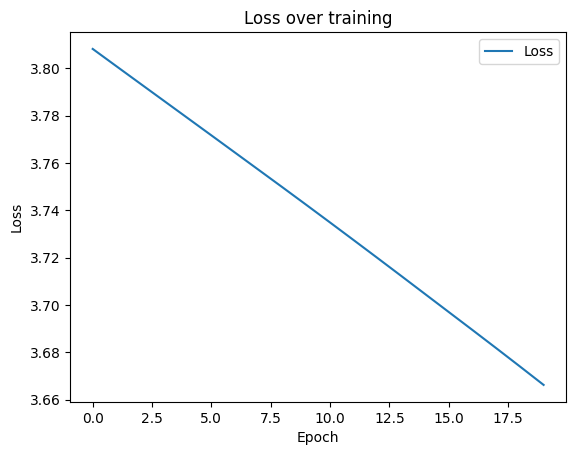

In [ ]:
np_loss_values = []

# This is for CUDA, can be removed if using CPU to run the model.
for v in loss_values:
    np_loss_value = v.cpu().detach().numpy()
    np_loss_values.append(np_loss_value)
print(np_loss_values)

# Replace np_loss_values with loss_values if using CPU.
plt.plot(np_loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over training')
plt.legend()
plt.show()

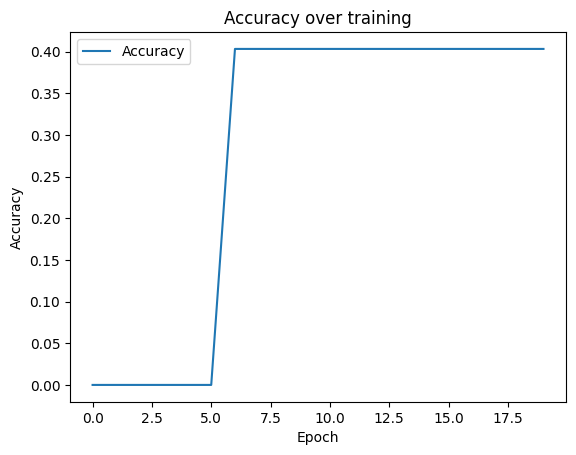

In [35]:
plt.plot(accuracy_values, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over training')
plt.legend()
plt.show()

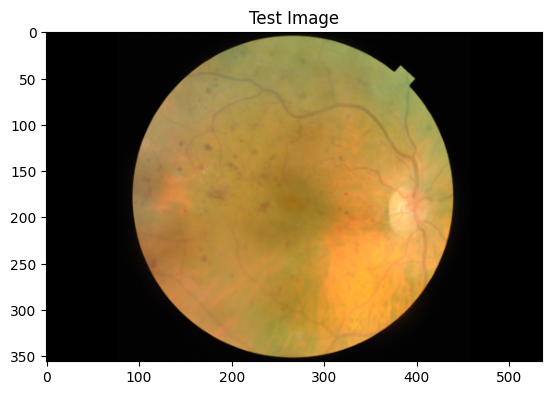

In [41]:
# Plotting example image in the test set using matplotlib
plt.imshow(test_res['image'][0].permute(1, 2, 0))
plt.title("Test Image")
plt.show()


# Analysis
- Plot loss/accuracy (y) with number of epochs ran (x)
- Recall/Precision/F1 score 

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(cnn_losses) + 1), cnn_losses, label="CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()